# Comparing our full model to the Kallenbach model

In this notebook, we compare our model for 1D radiation, convection and conduction to the Kallenbach model.

We first compare the model to an IDL-to-Python translation of the Kallenbach model, and then to values taken directly from the paper.

In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import cfspopcon
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from cfspopcon.unit_handling import magnitude_in_units, ureg

import extended_lengyel
plt.style.use('paper_plots.mplstyle')

Running in /Users/tbody/Projects/extended-lengyel/notebooks


First, we run the IDL-to-Python translation

In [2]:
kallenbach_algorithm = cfspopcon.Algorithm.get_algorithm("kallenbach_idl_translation")

ds_kallenbach = xr.Dataset(data_vars=extended_lengyel.read_config(
    filepath        = Path("config.yml"),
    elements        = ["base", "machine_geometry", "target_constraints", "fast_neutrals", "field_at_omp"],
    keys            = kallenbach_algorithm.input_keys,
    allowed_missing = kallenbach_algorithm.default_keys
))

kallenbach_algorithm.validate_inputs(ds_kallenbach)

ds_kallenbach                   = kallenbach_algorithm.update_dataset(ds_kallenbach)
ds_kallenbach["dim_s_parallel"] = ds_kallenbach["s_parallel"].pint.to(ureg.m).pint.magnitude

We then compare the results of the IDL-to-Python translation to values taken directly from the paper, and see that we're exactly reproducing the results.

(<Figure size 1920x1440 with 10 Axes>,
 array([[<Axes: ylabel='[$MW/m^3$]'>, <Axes: >],
        [<Axes: ylabel='[$Pa$]'>, <Axes: >],
        [<Axes: ylabel='[$eV$]'>, <Axes: >],
        [<Axes: ylabel='[$m^{-3}$]'>, <Axes: >],
        [<Axes: ylabel='[~]'>, <Axes: >]], dtype=object))

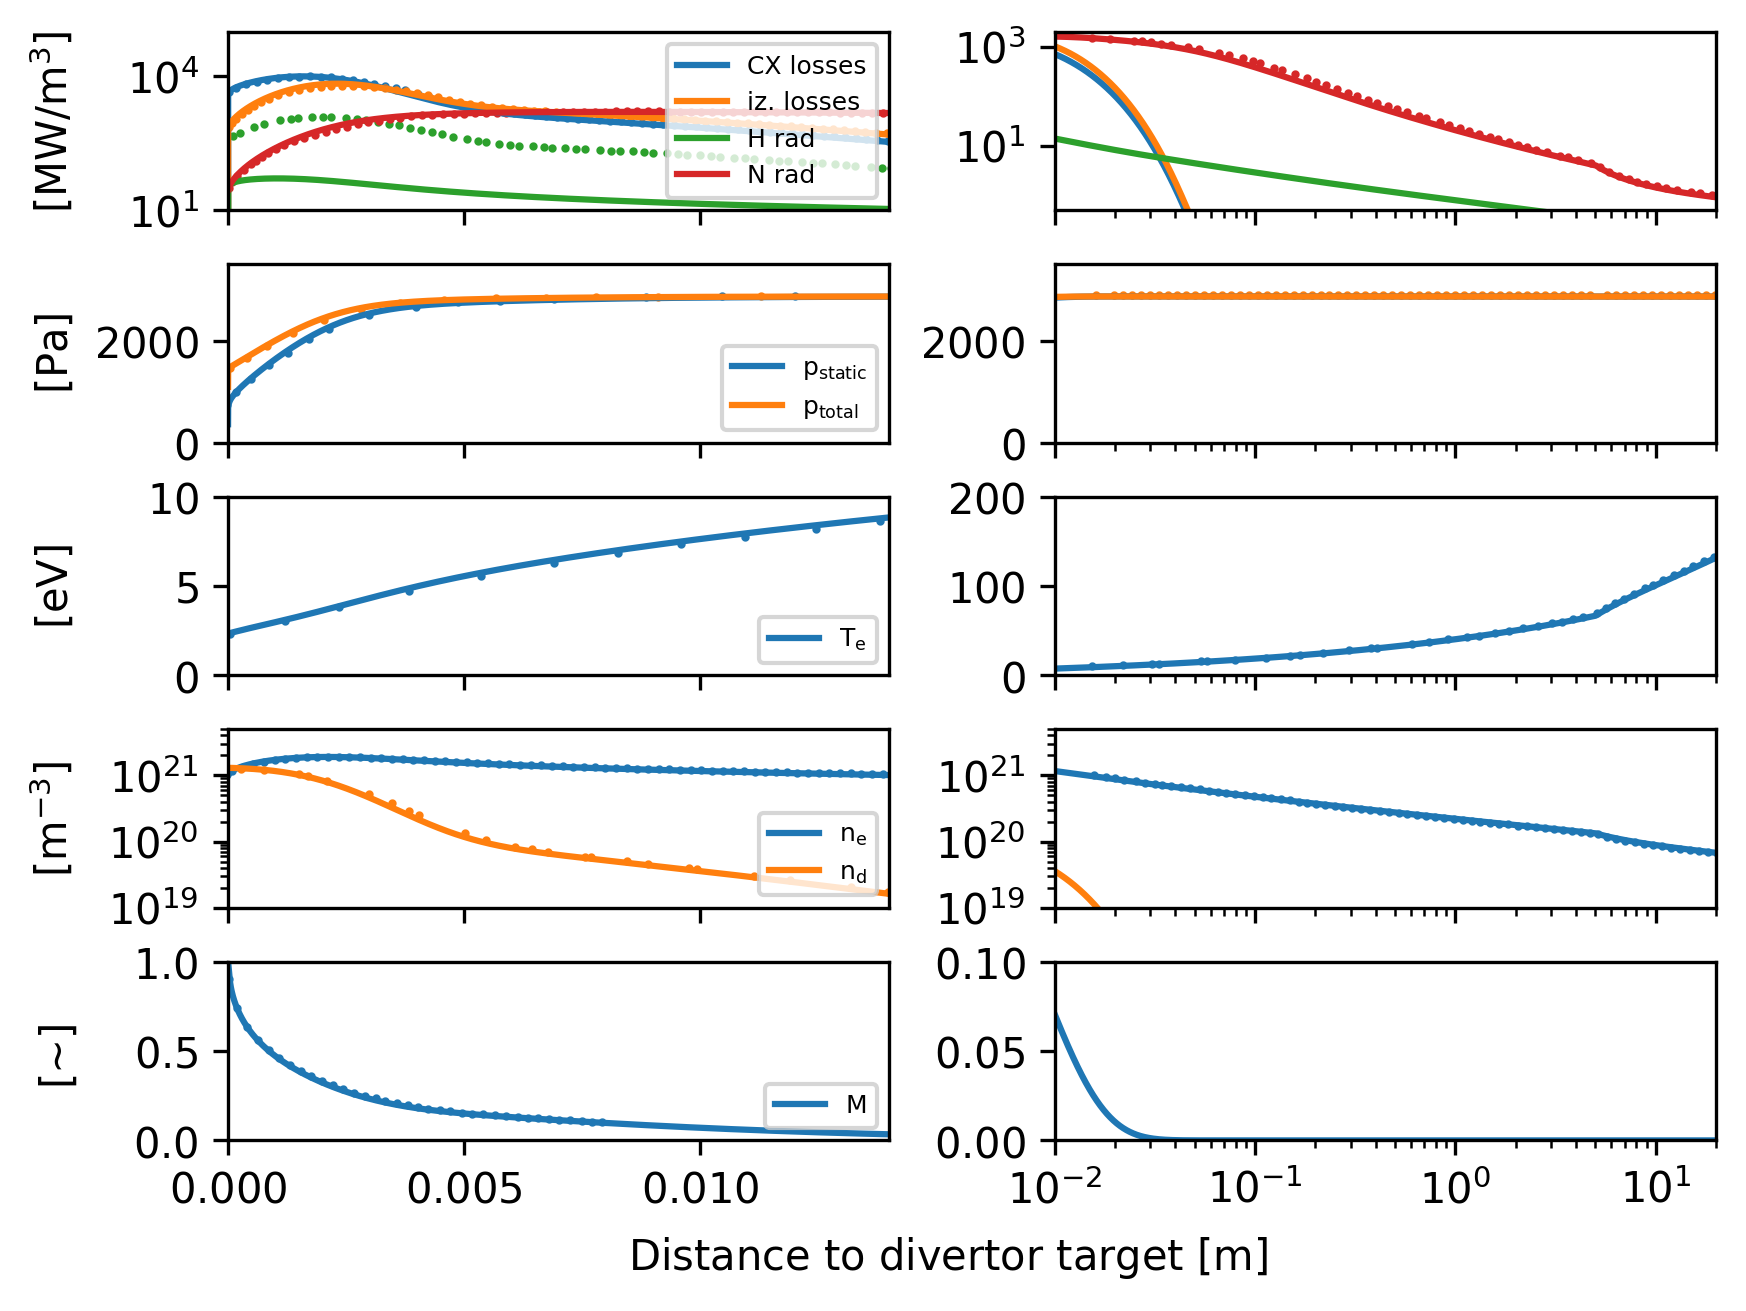

In [3]:
from cfspopcon.unit_handling import magnitude_in_units

from extended_lengyel.kallenbach_model.reference_data import read_kallenbach_figure_4_reference


def _plotter(ax, x, y, lineplot, **kwargs):

    if lineplot:
        ax.plot(x, y, **kwargs)
    else:
        kwargs = {k: v for k, v in kwargs.items() if k not in ["label"]}
        ax.scatter(x, y, **kwargs, s=1.0)

def plot_comparison_to_kallenbach_figure_4(datasets, show_ref = True):

    nrows, ncols = 5, 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex="col", dpi=300)

    if isinstance(datasets, xr.Dataset):
        datasets = [datasets]
    assert len(datasets) <= 2
    assert not(len(datasets) == 2 and show_ref)

    for ds, lineplot in zip(datasets, [True, False]):
        for col in [0, 1]:

            _plotter(axs[0][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["charge_exchange_power_loss"], ureg.MW/ureg.m**3), label="CX losses", lineplot=lineplot)
            _plotter(axs[0][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["ionization_power_loss"], ureg.MW/ureg.m**3), label="iz. losses", lineplot=lineplot)
            _plotter(axs[0][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["hydrogen_radiated_power"], ureg.MW/ureg.m**3), label="H rad", lineplot=lineplot)
            _plotter(axs[0][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["impurity_radiated_power"], ureg.MW/ureg.m**3), label="N rad", lineplot=lineplot)

            _plotter(axs[1][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["static_pressure"], ureg.Pa), label="$p_{static}$", lineplot=lineplot)
            _plotter(axs[1][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units((ds["static_pressure"] + ds["dynamic_pressure"]), ureg.Pa), label="$p_{total}$", lineplot=lineplot)

            _plotter(axs[2][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["electron_temp"], ureg.eV), label="$T_e$", lineplot=lineplot)

            _plotter(axs[3][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["electron_density"], ureg.m**-3), label="$n_e$", lineplot=lineplot)
            _plotter(axs[3][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(ds["neutral_density"], ureg.m**-3), label="$n_d$", lineplot=lineplot)

            _plotter(axs[4][col], magnitude_in_units(ds["s_parallel"], ureg.m), magnitude_in_units(-ds["mach_number"], ureg.dimensionless), label="M", lineplot=lineplot)

    # Set up x-axes
    axs[0][0].set_xlim(0, 1.4e-2)
    axs[0][1].set_xlim(1e-2, 20.0)
    axs[0][1].set_xscale("log")

    axs[0][0].set_yscale("log")
    axs[0][1].set_yscale("log")
    axs[0][0].set_ylim(1e1, 1e5)
    axs[0][1].set_ylim(5e-1, 2e3)
    axs[0][0].set_ylabel("[$MW/m^3$]")

    axs[1][0].set_ylim(0, 3500)
    axs[1][1].set_ylim(0, 3500)
    axs[1][0].set_ylabel("[$Pa$]")

    axs[2][0].set_ylim(0, 10)
    axs[2][1].set_ylim(0, 200)
    axs[2][0].set_ylabel("[$eV$]")

    axs[3][0].set_ylim(0.1e20, 50e20)
    axs[3][1].set_ylim(0.1e20, 50e20)
    axs[3][0].set_yscale("log")
    axs[3][1].set_yscale("log")
    axs[3][0].set_ylabel("[$m^{-3}$]")

    axs[4][0].set_ylim(0, 1)
    axs[4][1].set_ylim(0, 0.1)
    axs[4][0].set_ylabel("[~]")

    fig.align_ylabels(axs[:, 0])
    fig.subplots_adjust(hspace=0.3, wspace=0.25)
    fig.text(0.5, 0.02, "Distance to divertor target [$m$]", ha="center")

    for ax in axs[:, 0].flatten():
        ax.legend(fontsize=6, loc="lower right")

    kwargs = dict(
        s = 1.0
    )

    if show_ref:
        yaml_data = read_kallenbach_figure_4_reference()

        axs[0][0].scatter(yaml_data["charge_exchange_power_loss_left"]["x"], yaml_data["charge_exchange_power_loss_left"]["y"], **kwargs)
        axs[0][0].scatter(yaml_data["ionization_power_loss_left"]["x"], yaml_data["ionization_power_loss_left"]["y"], **kwargs)
        axs[0][0].scatter(yaml_data["hydrogen_radiation_left"]["x"], yaml_data["hydrogen_radiation_left"]["y"], **kwargs)
        axs[0][0].scatter(yaml_data["nitrogen_radiation_left"]["x"], yaml_data["nitrogen_radiation_left"]["y"], **kwargs)
        axs[0][1].scatter(yaml_data["nitrogen_radiation_right"]["x"], yaml_data["nitrogen_radiation_right"]["y"], **kwargs, color="C3")
        axs[1][0].scatter(yaml_data["static_pressure_left"]["x"], yaml_data["static_pressure_left"]["y"], **kwargs)
        axs[1][0].scatter(yaml_data["total_pressure_left"]["x"], yaml_data["total_pressure_left"]["y"], **kwargs)
        axs[1][1].scatter(yaml_data["total_pressure_right"]["x"], yaml_data["total_pressure_right"]["y"], **kwargs, color="C1")
        axs[2][0].scatter(yaml_data["electron_temp_left"]["x"], yaml_data["electron_temp_left"]["y"], **kwargs)
        axs[2][1].scatter(yaml_data["electron_temp_right"]["x"], yaml_data["electron_temp_right"]["y"], **kwargs)

        axs[3][0].scatter(yaml_data["electron_density_left"]["x"], yaml_data["electron_density_left"]["y"] * 1e20, **kwargs)
        axs[3][0].scatter(yaml_data["neutral_density_left"]["x"], yaml_data["neutral_density_left"]["y"] * 1e20, **kwargs)

        axs[3][1].scatter(yaml_data["electron_density_right"]["x"], yaml_data["electron_density_right"]["y"] * 1e20, **kwargs)

        axs[4][0].scatter(yaml_data["mach_number_left"]["x"], yaml_data["mach_number_left"]["y"], **kwargs)

    return fig, axs

plot_comparison_to_kallenbach_figure_4(ds_kallenbach)

## Comparing the full model to Kallenbach

In our model, we've dropped the "fast neutrals" since this term breaks particle flux conservation. As such, we can't compare directly to the paper, but we can compare to the translation of the Kallenbach model.

In [4]:
rcc_algorithm = cfspopcon.Algorithm.get_algorithm("kallenbach_model")

ds_rcc = xr.Dataset(data_vars=extended_lengyel.read_config(
    filepath        = Path("config.yml"),
    elements        = ["base", "target_constraints"],
    keys            = rcc_algorithm.input_keys,
    allowed_missing = rcc_algorithm.default_keys
))

rcc_algorithm.validate_inputs(ds_rcc)

ds_rcc                   = rcc_algorithm.update_dataset(ds_rcc)
ds_rcc["dim_s_parallel"] = ds_rcc["s_parallel"].pint.to(ureg.m).pint.magnitude

In [5]:
ds_kallenbach_no_fast_neutrals = xr.Dataset(data_vars=extended_lengyel.read_config(
    filepath        = Path("config.yml"),
    elements        = ["base", "machine_geometry", "target_constraints", "fast_neutrals", "field_at_omp"],
    keys            = kallenbach_algorithm.input_keys,
    allowed_missing = kallenbach_algorithm.default_keys,
    overrides       = dict(fast_neutral_fraction = 0.0),
))

kallenbach_algorithm.validate_inputs(ds_kallenbach_no_fast_neutrals)

ds_kallenbach_no_fast_neutrals                   = kallenbach_algorithm.update_dataset(ds_kallenbach_no_fast_neutrals)
ds_kallenbach_no_fast_neutrals["dim_s_parallel"] = ds_kallenbach_no_fast_neutrals["s_parallel"].pint.to(ureg.m).pint.magnitude

(<Figure size 1920x1440 with 10 Axes>,
 array([[<Axes: ylabel='[$MW/m^3$]'>, <Axes: >],
        [<Axes: ylabel='[$Pa$]'>, <Axes: >],
        [<Axes: ylabel='[$eV$]'>, <Axes: >],
        [<Axes: ylabel='[$m^{-3}$]'>, <Axes: >],
        [<Axes: ylabel='[~]'>, <Axes: >]], dtype=object))

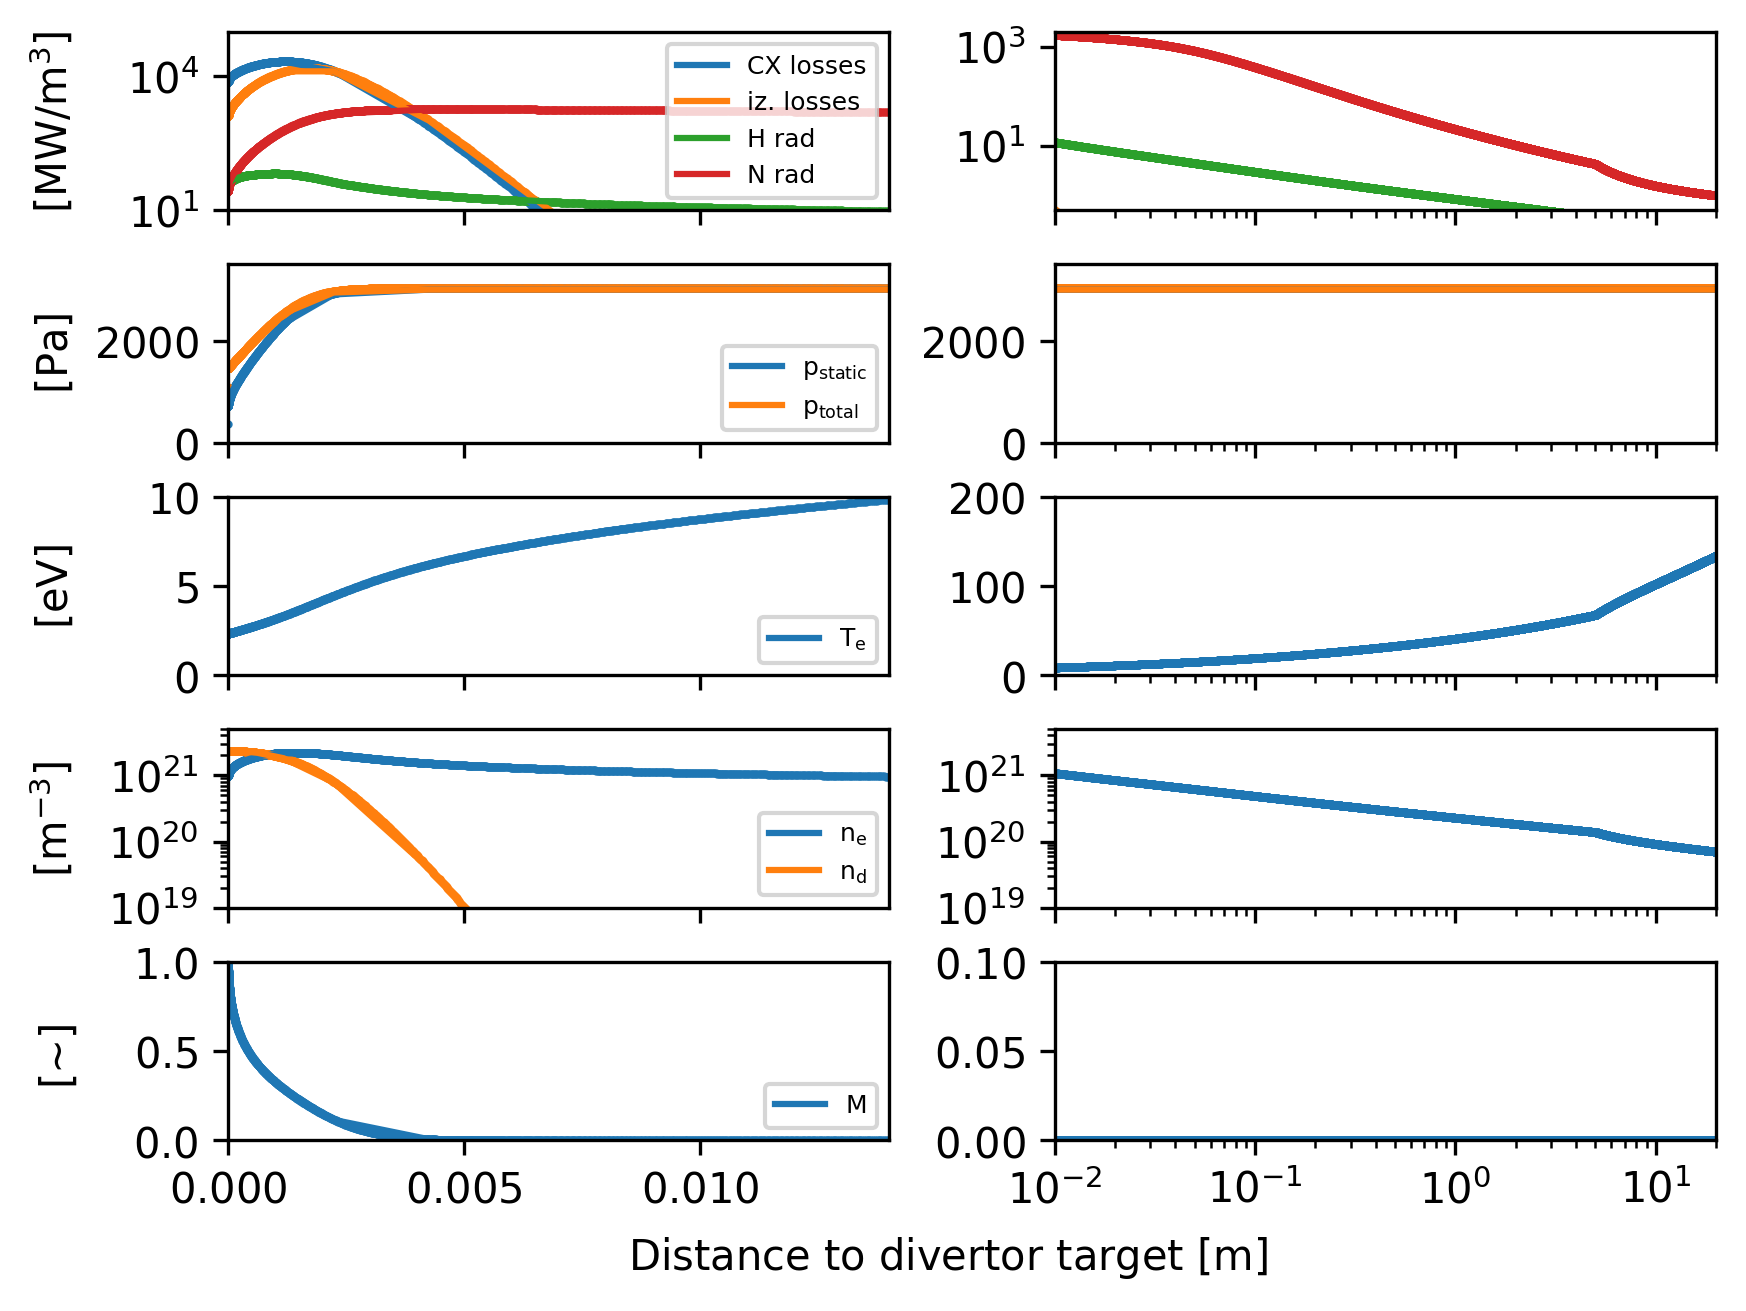

In [6]:
plot_comparison_to_kallenbach_figure_4([ds_rcc, ds_kallenbach_no_fast_neutrals], show_ref=False)

## Let's make a nice figure for the paper, including marking the 'conduction-convection' interface

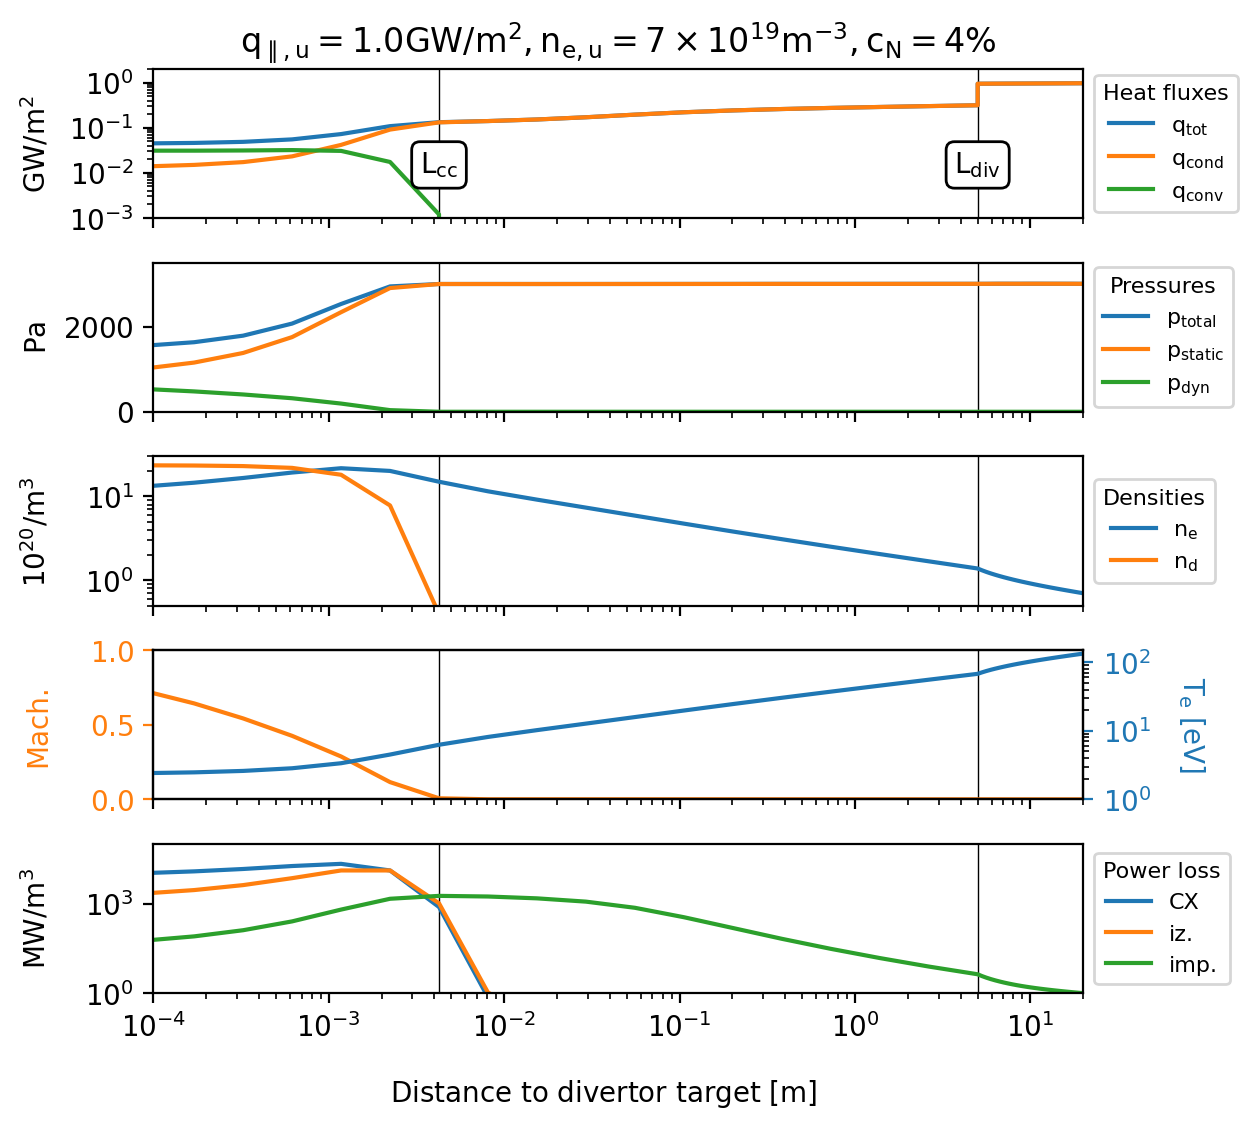

In [7]:
import extended_lengyel.directories


fig, axs = plt.subplots(nrows=5, dpi=200, sharex="col", figsize=(6, 6))

for ax in axs.flatten():
    ax.axhline(0.0, color="k", linewidth=0.1)
    ax.axvline(magnitude_in_units(ds_rcc["s_parallel_at_cc_interface"], ureg.m), color="k", linewidth=0.5)
    ax.axvline(magnitude_in_units(ds_rcc["divertor_parallel_length"], ureg.m), color="k", linewidth=0.5)

axs[0].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["parallel_heat_flux"], ureg.GW/ureg.m**2), label="$q_{tot}$")
axs[0].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["parallel_conductive_heat_flux"], ureg.GW/ureg.m**2), label="$q_{cond}$")
axs[0].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["parallel_convective_heat_flux"], ureg.GW/ureg.m**2), label="$q_{conv}$")
axs[0].set_ylabel("$GW / m^2$")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-3, 2)
axs[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8, title="Heat fluxes", title_fontsize=8)

axs[0].text(x=magnitude_in_units(ds_rcc["s_parallel_at_cc_interface"], ureg.m), y=1.5e-2, s="$L_{cc}$", ha="center", va="center", bbox=dict(boxstyle="round", ec="k", fc="w"))
axs[0].text(x=magnitude_in_units(ds_rcc["divertor_parallel_length"], ureg.m), y=1.5e-2, s="$L_{div}$", ha="center", va="center", bbox=dict(boxstyle="round", ec="k", fc="w"))

axs[1].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["total_pressure"], ureg.Pa), label="$p_{total}$")
axs[1].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["static_pressure"], ureg.Pa), label="$p_{static}$")
axs[1].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["dynamic_pressure"], ureg.Pa), label="$p_{dyn}$")
axs[1].set_ylabel("$Pa$")
axs[1].set_ylim(0, 3500)
axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8, title="Pressures", title_fontsize=8)

axs[2].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["electron_density"], ureg.n20), label="$n_e$")
axs[2].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["neutral_density"], ureg.n20), label="$n_d$")
axs[2].set_ylabel("$10^{20}/m^3$")
axs[2].set_ylim(0.5, 30)
axs[2].set_yscale("log")
axs[2].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8, title="Densities", title_fontsize=8)

axs[3].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), -magnitude_in_units(ds_rcc["mach_number"], ureg.dimensionless), color="C1", label="$M$")
axs[3].set_ylim(0, 1)
axs[3].set_ylabel("Mach.", color="C1")
axs[3].tick_params(axis="y", colors="C1")

ax2 = axs[3].twinx()
ax2.plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["electron_temp"], ureg.eV), label="$T_e / 100eV$")
ax2.set_ylim(1, 150)
ax2.set_yscale("log")
ax2.set_ylabel("$T_e$ [eV]", color="C0", rotation=270, labelpad=20)
ax2.tick_params(axis="y", colors="C0")

axs[4].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["charge_exchange_power_loss"], ureg.MW / ureg.m**3), label="CX")
axs[4].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["ionization_power_loss"], ureg.MW / ureg.m**3), label="iz.")
axs[4].plot(magnitude_in_units(ds_rcc["s_parallel"], ureg.m), magnitude_in_units(ds_rcc["impurity_radiated_power"], ureg.MW / ureg.m**3), label="imp.")
axs[4].set_yscale("log")
axs[4].set_ylim(1, 1e5)
axs[4].set_ylabel("$MW/m^3$")
axs[4].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8, title="Power loss", title_fontsize=8)

q_par_u = magnitude_in_units(ds_rcc["q_parallel"], "GW/m^2")
n_eu = magnitude_in_units(ds_rcc["separatrix_electron_density"], "n19")
c_z = magnitude_in_units(ds_rcc["impurity_fraction"], "%")
axs[0].set_title(f"$q_{{\\parallel,u}}={q_par_u:.1f}GW/m^2, n_{{e,u}}={n_eu:.0f}\\times10^{{19}}m^{{-3}}, c_{{N}}={c_z:.0f}\\%$")
axs[0].set_xscale("log")
axs[0].set_xlim(1e-4, magnitude_in_units(ds_rcc["parallel_connection_length"], ureg.m))

fig.align_ylabels(axs)
fig.subplots_adjust(hspace=0.3, wspace=0.25)
fig.text(0.5, 0.02, "Distance to divertor target [$m$]", ha="center")

plt.savefig(extended_lengyel.directories.output_dir / "Kallenbach_parallel_profile.png", dpi=300, bbox_inches="tight")